# A causal look into the factors of world happiness [3-Causal learning]

## intro
In this one we will try causal graph learning on our dataset. There are different algorithms to discover causal graphs from data. We are going to use `causal-learn` library.

Let's start with the usual dataset loading steps. Here the mapping of the variables:
```
Y: Ladder score
D: "treatment" status indicator, we will try to do some interventions
   on some subset of the records (for example, what happens if income raises...)
   this binary label will be set to 1 for the records that received the intervention.
X: a matrix of all the covariates used in the dataset (Y  S  J  X  W)
```

Discalimer: figures below may differ if recomputed as those are results of probabilistic models

## load the dataset

In [1]:
import pandas as pd
from causalinference import CausalModel
from tabulate import tabulate
from functools import partial
def flatten(xss):
    return [x for xs in xss for x in xs]

In [2]:
df = pd.read_csv('world-happiness-report-2021.csv')
df.drop(list(df.filter(regex='Explained')), axis=1, inplace=True)
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,2.798


In [3]:
df = df[["Ladder score",
         "Logged GDP per capita",
         "Social support",
         "Healthy life expectancy",
         "Freedom to make life choices"]
].copy()
df.rename(columns={
    "Ladder score": "Y",
    "Logged GDP per capita": "S",
    "Social support": "J",
    "Healthy life expectancy": "X",
    "Freedom to make life choices": "W" 
}, inplace=True)
df.head(5)

,Y,S,J,X,W
0,7.842,10.775,0.954,72.0,0.949
1,7.620,10.933,0.954,72.7,0.946
2,7.571,11.117,0.942,74.4,0.919
3,7.554,10.878,0.983,73.0,0.955
4,7.464,10.932,0.942,72.4,0.913


In [4]:
df.describe()

,Y,S,J,X,W
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.532839,9.432208,0.814745,64.992799,0.791597
std,1.073924,1.158601,0.114889,6.762043,0.113332
min,2.523000,6.635000,0.463000,48.478000,0.382000
25%,4.852000,8.541000,0.750000,59.802000,0.718000
50%,5.534000,9.569000,0.832000,66.603000,0.804000
75%,6.255000,10.421000,0.905000,69.600000,0.877000
max,7.842000,11.647000,0.983000,76.953000,0.970000


In [5]:
print(df.columns)

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

Index(['Y', 'S', 'J', 'X', 'W'], dtype='object')


## Causal discovery

Let's use FCI as provided by `causal-learn` and designed by [1] to spot the causal relations from the dataset.

/home/lorenzo/code/notepad/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Fast Adjacency Search.


Depth=3, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 155.34it/s]


Finishing Fast Adjacency Search.
X1 --> X5


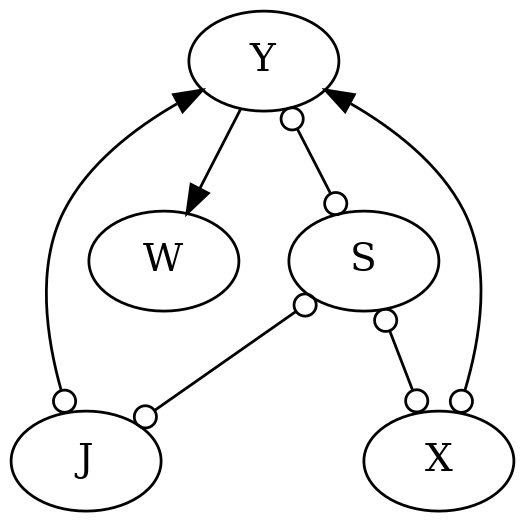

In [6]:
from causallearn.search.ConstraintBased.FCI import fci
G = fci(df.to_numpy())

# visualization
from causallearn.utils.GraphUtils import GraphUtils
dot = GraphUtils.to_pydot(G[0], labels=df.columns)

view_pydot(dot)

Let's run another algorithm for comparison: Peter-Clark (PC) [2]

Depth=3, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 54.37it/s] 


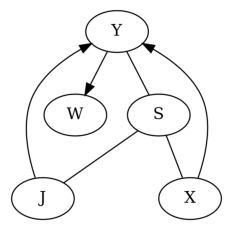

In [7]:
from causallearn.search.ConstraintBased.PC import pc
cg = pc(df.to_numpy())

# visualization using pydot
cg.draw_pydot_graph(labels=df.columns)

The graph discovered includes only 4 variables, there seems to be no causal relation that involves `S`.


## Graphical Causal Model


Let's now try to run causal inference on the discovered graph: we start using Graphical Causal Modelling and then the Causal Inference itself. 

In [8]:
from dowhy import gcm
import networkx as nx

columns_order = ["X", "J", "W", "Y"]

scm = gcm.StructuralCausalModel(nx.DiGraph([("X", "Y"), ("J", "Y"), ("Y", "W")]))

scm.set_causal_mechanism(
    'X', gcm.EmpiricalDistribution())
scm.set_causal_mechanism(
    'J', gcm.EmpiricalDistribution())
scm.set_causal_mechanism(
    'W', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism(
    'Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(scm, df)

Fitting causal mechanism of node W: 100%|██████████| 4/4 [00:00<00:00, 79.45it/s]


Now that we have a fairly better established causal model, we can retry the intervention routines.

Let's try these "atomic" interventions:
1. control `X`
2. control `X` using SVM
3. control `X` using Random Forest

### 1. control X

Let's do **intervention 1** by setting `X=min(X)` and `X=median(X)`:

In [9]:
def do_intervention_atomic(model, covariate, value):
    "Make an intervention by setting a covariate to a given VALUE"
    return gcm.interventional_samples(
        model,
        {covariate: lambda _: value},
        num_samples_to_draw=149
    )

min_x = df["X"].min()
median_x = df["X"].median()

# take a random sample of 3 countries
sample_df01 = df.sample(
    n=3, random_state=10101, ignore_index=False).copy()
sample_indices01 = sample_df01.index
original01 = df.iloc[sample_indices01[1]]


#
# intervention 1: min(X)
#
print(f"Atomic Intervention: Set value X=min(X)={min_x}")
intervention01_on_x = do_intervention_atomic(
    scm,
    "X",
    df["X"].min()
).iloc[sample_indices01[1]]

table01 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=min(X)", sample_indices01[1]] + intervention01_on_x[columns_order].to_list()]

print(tabulate(table01, headers=["action", "i"] + columns_order))
print("\n")


#
# intervention 2: median(X)
#
print(f"Atomic Intervention: Set value X=median(X)={median_x}")
intervention02_on_x = do_intervention_atomic(
    scm,
    "X",
    df["X"].median()
).iloc[sample_indices01[1]]

table02 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=median(X)", sample_indices01[1]] + intervention02_on_x[columns_order].to_list()]

print(tabulate(table02, headers=["action", "i"] + columns_order))

original_value = df.loc[sample_indices01[1]]["Y"]
interv1_value = intervention01_on_x[columns_order].to_list()[-1]
interv2_value = intervention02_on_x[columns_order].to_list()[-1]
del scm, intervention01_on_x, intervention02_on_x


Atomic Intervention: Set value X=min(X)=48.478
action      i       X      J         W        Y
--------  ---  ------  -----  --------  -------
original   75  64.703  0.903  0.718     5.477
X=min(X)   75  48.478  0.893  0.711354  3.91403


Atomic Intervention: Set value X=median(X)=66.603
action         i       X      J         W        Y
-----------  ---  ------  -----  --------  -------
original      75  64.703  0.903  0.718     5.477
X=median(X)   75  66.603  0.764  0.733672  5.43697


We can now starting to compare true causal effects and climb to the second step of the Ladder of Causation (understanding through intervention). Our causal model has been generated by causal algorithms (that can return slightly different results according to type of algorithm and parameters obviously but can assure a formal consistency). After four posts we can start to say something.

The expected "gain/loss" in controlling for `X` (Life expectancy) in terms of `Y` (Ladder score, aka "happiness index relatively to a dystopia") for country 75 (but we could easily compute the average of all countries) is:

* in the case of reducing the expectancy to the minimum:

$E_{75} ( Y_{75}^{do(X=min)}(1)-Y_{75}(0) ) $ = 3.91403 - 5.477 = −1.56297

* in the case of raising life expectancy to the median:

$E_{75} ( Y_{75}^{do(X=median)}(1)-Y_{75}(0) )  $ = 5.43697 - 5.477 = −0.04003

These results are consistent to what we could expect: a life expectancy lowered by 20 years pulls down "happiness" quite evidently, on the other side increasing the life expectancy by 2 years may have a limited effect (always keep in mind statistical error).

We can probaly improve this view by adjusting the mechanism that transmit between `X` and `Y`. in fact we would probably not expect (by human logical reasoning) to see a decrease in "happines" if life expectancy goes up by even the slightest increase. Let's try the same model with a different mechanism

### 2. control X using SVM


In [10]:
scm2 = gcm.StructuralCausalModel(nx.DiGraph([("X", "Y"), ("J", "Y"), ("Y", "W")]))

scm2.set_causal_mechanism(
    'X', gcm.EmpiricalDistribution())
scm2.set_causal_mechanism(
    'J', gcm.EmpiricalDistribution())
scm2.set_causal_mechanism(
    'W', gcm.AdditiveNoiseModel(gcm.ml.create_support_vector_regressor()))  # <--- both changes to SVM
scm2.set_causal_mechanism(
    'Y', gcm.AdditiveNoiseModel(gcm.ml.create_support_vector_regressor()))

gcm.fit(scm2, df)

Fitting causal mechanism of node W: 100%|██████████| 4/4 [00:00<00:00, 78.16it/s]


Let's perform the same interventions as before but using a Support Vector Machine model as mechanisms for both ingoing and outgoing relations from `Y`:

In [11]:
#
# intervention 3 (SVM): min(X)
#
print(f"Atomic Intervention: Set value X=min(X)={min_x}")
intervention03_on_x = do_intervention_atomic(
    scm2,
    "X",
    df["X"].min()
).iloc[sample_indices01[1]]

table03 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=min(X)", sample_indices01[1]] + intervention03_on_x[columns_order].to_list()]

print(tabulate(table03, headers=["action", "i"] + columns_order))
print("\n")


#
# intervention 4 (SVM): median(X)
#
print(f"Atomic Intervention: Set value X=median(X)={median_x}")
intervention04_on_x = do_intervention_atomic(
    scm2,
    "X",
    df["X"].median()
).iloc[sample_indices01[1]]

table04 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=median(X)", sample_indices01[1]] + intervention04_on_x[columns_order].to_list()]

print(tabulate(table04, headers=["action", "i"] + columns_order))

del scm2, intervention03_on_x, intervention04_on_x

Atomic Intervention: Set value X=min(X)=48.478
action      i       X      J         W        Y
--------  ---  ------  -----  --------  -------
original   75  64.703  0.903  0.718     5.477
X=min(X)   75  48.478  0.71   0.687136  4.20372


Atomic Intervention: Set value X=median(X)=66.603
action         i       X      J         W        Y
-----------  ---  ------  -----  --------  -------
original      75  64.703  0.903  0.718     5.477
X=median(X)   75  66.603  0.893  0.915142  5.71135


We can see at first sight that these are better estimation for the me mechanism between `X` and `Y`:

The expected "gain/loss" in controlling for `X` (Life expectancy) in terms of `Y` (Ladder score, aka "happiness index relatively to a dystopia") for country 75 (but we could easily compute the average of all countries) is:

* in the case of reducing the expectancy to the minimum (with SVM): $E_{75}^{SVM} ( Y_{75}^{do(X=min)}(1)-Y_{75}(0) ) = 4.20372 - 5.477 = −1.27328 $

* in the case of raising life expectancy to the median (with SVM): $E_{75}^{SVM} ( Y_{75}^{do(X=median)}(1)-Y_{75}(0) ) = 5.71135 - 5.477 = 0.23435 $

This is more consistent with causal reasoning, reducing by 20 years reduces a lot "happiness", increasing by 2 increases slightly "happiness". SVM seems to model better the causal relation between life expectancy and "happiness". We may have desired a higher decrease for $E_{75}^{SVM}$. What about a Random Forest mechanism?

## 3. control X using Random Forest

Same as 2. let;s generate a new causal model, but this time we set a Random Forest regressor for relation ingoing `Y` but keeping outgoing relation to be a linear mechanism:

In [12]:
scm3 = gcm.StructuralCausalModel(nx.DiGraph([("X", "Y"), ("J", "Y"), ("Y", "W")]))

scm3.set_causal_mechanism(
    'X', gcm.EmpiricalDistribution())
scm3.set_causal_mechanism(
    'J', gcm.EmpiricalDistribution())
scm3.set_causal_mechanism(
    'W', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())) # <--- still linear
scm3.set_causal_mechanism(
    'Y', gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

gcm.fit(scm3, df)

Fitting causal mechanism of node W: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]


In [13]:
#
# intervention 5 (RF): min(X)
#
print(f"Atomic Intervention: Set value X=min(X)={min_x}")
intervention05_on_x = do_intervention_atomic(
    scm3,
    "X",
    df["X"].min()
).iloc[sample_indices01[1]]

table05 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=min(X)", sample_indices01[1]] + intervention05_on_x[columns_order].to_list()]

print(tabulate(table05, headers=["action", "i"] + columns_order))
print("\n")


#
# intervention 6 (RF): median(X)
#
print(f"Atomic Intervention: Set value X=median(X)={median_x}")
intervention06_on_x = do_intervention_atomic(
    scm3,
    "X",
    df["X"].median()
).iloc[sample_indices01[1]]

table06 = [
    ["original", sample_indices01[1]] + original01[columns_order].to_list(),
    ["X=median(X)", sample_indices01[1]] + intervention06_on_x[columns_order].to_list()]

print(tabulate(table06, headers=["action", "i"] + columns_order))

Atomic Intervention: Set value X=min(X)=48.478
action      i       X      J         W        Y
--------  ---  ------  -----  --------  -------
original   75  64.703  0.903  0.718     5.477
X=min(X)   75  48.478  0.767  0.696522  4.12787


Atomic Intervention: Set value X=median(X)=66.603
action         i       X      J         W        Y
-----------  ---  ------  -----  --------  -------
original      75  64.703  0.903  0.718     5.477
X=median(X)   75  66.603  0.672  0.911946  5.26091


I leave to the reader telling if this does better of worse than 2.:
* in the case of reducing the expectancy to the minimum (with RF): $E_{75}^{RF} ( Y_{75}^{do(X=min)}(1)-Y_{75}(0) ) = 4.12787 - 5.477 = −1.34913 $

* in the case of raising life expectancy to the median (with RF): $E_{75}^{RF} ( Y_{75}^{do(X=median)}(1)-Y_{75}(0) ) = 4.73129 - 5.477 = −0.74571 $


Here it is the post about using `doWhy` for causal inference. We have used both the graphical tools on the graph and numerical tools on a single record. Next time we will compute ATE, ATC and ATT by defining the `D` column and formalising the intervenetions.


To get in touch you can contact me [here](https://www.linkedin.com/in/lorenzomoriondo/), or at https://pramantha.net

## References

[1] Spirtes, P., Meek, C., & Richardson, T. (1995, August). Causal inference in the presence of latent variables and selection bias. In Proceedings of the Eleventh conference on Uncertainty in artificial intelligence (pp. 499-506).

[2] Spirtes, P., Glymour, C. N., Scheines, R., & Heckerman, D. (2000). Causation, prediction, and search. MIT press.
